# Exploratory Data Analysis

## Problem Statement and Background

In this project, we will attempt to discover the features behind the popular music of each generation. For instance, if Britney Spears, “Oops I Did It Again” made the charts in 2001, and The Beatles’ “Real Love” made the charts in 1996, we want to see what made the music popular back then – was it the timbre, audio quality, or lyrics? We will then attempt to build a model that is able to predict whether a song will be popular or not, and will also attempt to apply it to modern music. 

Questions: 
1. What features best predict the popularity of a song?
2. Do those features change with time?
3. Do different features change how long it takes for a song to become popular?

This is an interesting problem because it can be used to create music which is more likely to become popular. 

## Data Sources you Intend to Use?


The Dataset that we are using is the Million Song Dataset, which can be found here: http://labrosa.ee.columbia.edu/millionsong/. 

We are initially using the subset (10,000 songs) of the entire dataset, and once we are confident we have a substantial model, we will then expand the database and include all million songs, while running our model on an EC2 server.

## Data Flaws, Weaknesses, and Cleaning

### Missing and Mislabelled Data. (Cleaning)
There is quite a bit of missing data (roughly 20%), which makes sense given the number of fields (as highlighted below) and the number of songs that they collected the data over. The missing fields are represented as NaNs.

To handle the missing data, we will exclude that data point from our analysis.

There is no duplicate data (as promised by the data source), but we will do fuzzy joins totry to match potentially mislabelled data in the dataset to real world data. 

### Data Access and Joins
Currently, the data is denormalized into a HDF5 data model for every song. In order to process them, we will have to enumerate through each file to find out more about its characteristics. However, for more generic ones like all the names of the artistes, we will be using the databases that are provided in the .db format. We will then extract more information by performing an equi-join on the `idx_artist_id` field (which is a primary key in the `subset_track_metadata.db` file, and a foreign key in most of the other databases). To do this, we use the sqlite3 library in Python which will help us run SQL queries.

### Data Weaknesses - Confidence
Almost every field in the dataset has a confidence level, e.g. how confident the EchoNest API is that the value provided is correct. For instance, the `key` attribute might be a 0 (which corresponds to a C in the musical world), but the `key_confidence` only shows a low 0.19 (or 19%), which means that it is not confident that the guess is correct. To help address this issue, we will be testing a range of values and then pick the best percentage that would give our model the best prediction rates (e.g. cross-validate by splitting into testing and training data).


## Basic Exploration

We've started by pulling out some summary statistics from a 1.8Gb (10,000 song) subset of the main Million Song data set. Some questions we wanted to begin assessing are how many unique artists are in the dataset, what is the geographic distribution of the data, average duration of songs, and are there any obvious correlations between features. The below code answers several of those questions. 

In [33]:
import os, sys, time, glob, csv, math, datetime, sqlite3, numpy as np, pdb # Crucial libraries
import matplotlib.mlab as mlab, matplotlib.pyplot as plt # Plotting libraries
import h5py as parser
import pprint
from scipy import stats
from collections import Counter

%matplotlib inline

# Note by Sidwyn:
# Pdb is useful for debugging. Simply put pdb.set_trace() and it will stop at that breakpoint.

# Path to the Million Song Dataset subset
msd_subset_path='/Users/maxwolffe/Documents/Cal/Fall2015/CS194/MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
assert os.path.isdir(msd_subset_path),'wrong path' # sanity check

# Path to the Million Song Dataset code
msd_code_path='/Users/maxwolffe/Documents/Cal/Fall2015/CS194/MillionSongSubset/MSongsDB'
assert os.path.isdir(msd_code_path),'wrong path' # sanity check
sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

import hdf5_getters # This has to be after the above for $PATH reasons.

There are 4412 distinct artists in our 10,000 song subset
The mean duration of the songs is 3.98 minutes with a std dev of 1.90, min of 0.02, and a max of 30.33


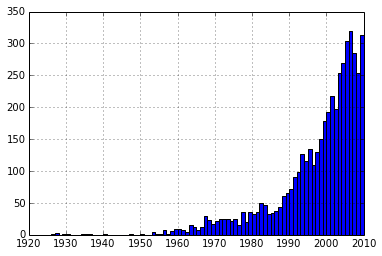

The song years range from 1926 to 2010
There are the most (320 songs) from 2006
The r-squared value for Familiartiy of artist vs. Hotness of Artist is 0.67210


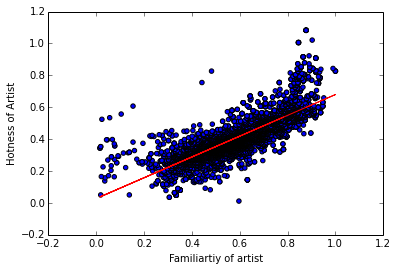

In [36]:
from setup import *

pp = pprint.PrettyPrinter(indent=2) 
allKeys = []
allLocations = []

allEnergy = []
allDance = []
allHotness = []
allTempo = []
allLoudness = []

def getKeysOfSongs(h5):
    key = h5['/analysis/songs']['key'][0]
    if h5['/analysis/songs']['key_confidence'][0] > 0.7: # 70% threshold for EchoNest to guess the key correctly
        allKeys.append(key)

def getEnergyOfSongs(h5):
    energy = h5['/analysis/songs']['energy'][0]
    if energy: 
        print energy
        allEnergy.append(energy)

def getDanceOfSongs(h5):
    danceability = h5['/analysis/songs']['danceability'][0]
    if danceability: 
        print danceability
        allDance.append(danceability)

def getSongHotness(h5):
    hotness = h5['/metadata/songs']['song_hotttnesss'][0]
    if hotness and not math.isnan(hotness): 
        if math.isnan(hotness):
            allHotness
        allHotness.append(hotness)

def getTempoOfSong(h5):
    tempo = h5['/analysis/songs']['tempo'][0]
    if tempo and not math.isnan(tempo): 
        allTempo.append(tempo)

def getLocationOfSongs(h5):
    lat = h5['/metadata/songs']['artist_latitude'][0]
    lon = h5['/metadata/songs']['artist_longitude'][0]
    if lat and lon and not math.isnan(lat) and not math.isnan(lon):
        allLocations.append([lat, lon])

def compareTwo(h5, x_info, y_info, x_arr, y_arr):
    x = h5['/'+x_info[0]+'/songs'][x_info[1]][0]
    if x and not math.isnan(x): 
        y = h5['/'+y_info[0]+'/songs'][y_info[1]][0]
        if y and not math.isnan(y): 
            x_arr.append(x)
            y_arr.append(y)

def countUniqueArtists():
    conn = sqlite3.connect(os.path.join(msd_subset_addf_path,
                                        'subset_track_metadata.db'))
    q = "SELECT DISTINCT artist_name FROM songs"
    res = conn.execute(q)
    all_artist_names_sqlite = res.fetchall()
    conn.close()

    print "There are " +str(len(all_artist_names_sqlite)) + " distinct artists in our 10,000 song subset"

def averageLengthOfSongs():
    conn = sqlite3.connect(os.path.join(msd_subset_addf_path,
                                        'subset_track_metadata.db'))
    q = "SELECT duration FROM songs"
    res = conn.execute(q)
    all_durations = res.fetchall()
    durations = [duration[0] for duration in all_durations if duration[0]]

    conn.close()

    print "The mean duration of the songs is " + "{:.2f}".format((np.mean(durations)/60.0)) + " minutes with a std dev of " + \
     "{:.2f}".format((np.std(durations)/60.0)) + ", min of " + "{:.2f}".format((min(durations)/60.0)) + ", and a max of " + "{:.2f}".format((max(durations)/60.0))

def studyYears():
    conn = sqlite3.connect(os.path.join(msd_subset_addf_path,
                                        'subset_track_metadata.db'))
    q = "SELECT year FROM songs"
    res = conn.execute(q)
    all_years = res.fetchall()
    years = [year[0] for year in all_years if year[0]]
    conn.close()

    plt.hist(years, bins=100, range=(1910,2010))
    plt.grid(True)
    plt.show()

    print "The song years range from " + str(min(years)) + " to " + str(max(years))

    yearCount = Counter(years)

    print "There are the most ("+str(yearCount.most_common(1)[0][1])+" songs) from " + str(yearCount.most_common(1)[0][0])      

def compareArtist():
    conn = sqlite3.connect(os.path.join(msd_subset_addf_path,
                                        'subset_track_metadata.db'))
    q = "SELECT artist_familiarity, artist_hotttnesss FROM songs"
    res = conn.execute(q)
    results = res.fetchall()
    familiarity = [result[0] for result in results if result[0] and result[1]]
    hotness = [result[1] for result in results if result[0] and result[1]]

    conn.close()
    makeScatterPlot(familiarity, hotness, "Familiartiy of artist", "Hotness of Artist")

def enumerateFiles():
    count = 0

    for root, dirs, files in os.walk(msd_subset_data_path):
        files = glob.glob(os.path.join(root,'*.h5'))
        count = len(files)
        for f in files:
                with parser.File(f, 'r') as h5:
                    # Running each of the following lines takes time.
                    getKeysOfSongs(h5)
                    getLocationOfSongs(h5)
                    #getEnergyOfSongs(h5)
                    #getDanceOfSongs(h5)
                    #compareTwo(h5, ['metadata', 'song_hotttnesss'], ['analysis', 'tempo'], allHotness, allTempo)
                    compareTwo(h5, ['analysis', 'loudness'], ['analysis', 'tempo'], allLoudness, allTempo)
                    compareTwo(h5, ['analysis', 'loudness'], ['analysis', 'tempo'], allLoudness, allTempo)
    plotAll()

def makeScatterPlot(x, y, xlabel, ylabel):
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    m, b = np.polyfit(x, y, 1) # compute linear regression line
    plt.plot(x, m*x + b, '-', color='red')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_squared = r_value * r_value
    print "The r-squared value for " +xlabel + " vs. " + ylabel + " is " + "{:.5f}".format(r_squared)
    plt.show()
    
def makeScatterPlot(x, y, xlabel, ylabel):
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    m, b = np.polyfit(x, y, 1) # compute linear regression line
    plt.plot(x, m*x + b, '-', color='red')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_squared = r_value * r_value
    print "The r-squared value for " +xlabel + " vs. " + ylabel + " is " + "{:.5f}".format(r_squared)
    plt.show()


def plotAll():
    print "beginning plotting"
    # Extract all location information into a csv
    # with open('location.csv', 'w') as fp:
    #     a = csv.writer(fp, delimiter=',')
    #     a.writerow(['lat', 'lon'])
    #     a.writerows(allLocations)

    #Plot keys of the subset
    plt.hist(allKeys)
    plt.grid(True)
    plt.show()
    makeScatterPlot(allLoudness, allTempo, "Loudness of Song", "Tempo of Song")
    #print(r_value)


#enumerateFiles()

#plotAll()
countUniqueArtists()
averageLengthOfSongs()
studyYears()
compareArtist()

Our first set of exploratory statistics explores unique artist count, summary statistics of song duration, year coverage and density. 

Our last figure is a scatter plot of Artist familiarity vs Artist hotness with a linear regression line. The correlation coefficient r2 =0.67210 which shows the positive correlation between the how hot a artist is and how familiar they are. These findings make sense.


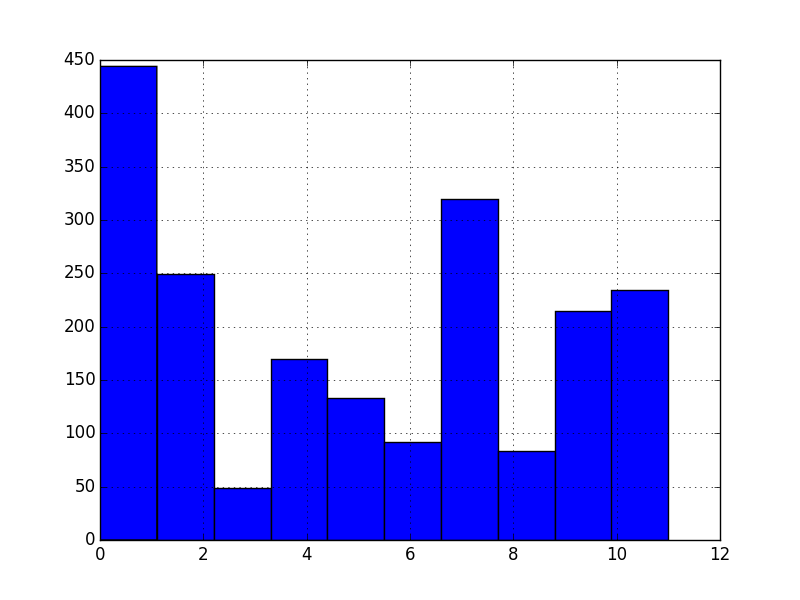

In [5]:
from IPython.display import Image
Image(filename='key.png')

Figure 1. Histogram of keys in the subset of songs. The most popular key out of the 10000 songs is the key of C. Only those that had a 70% confidence and above were included.

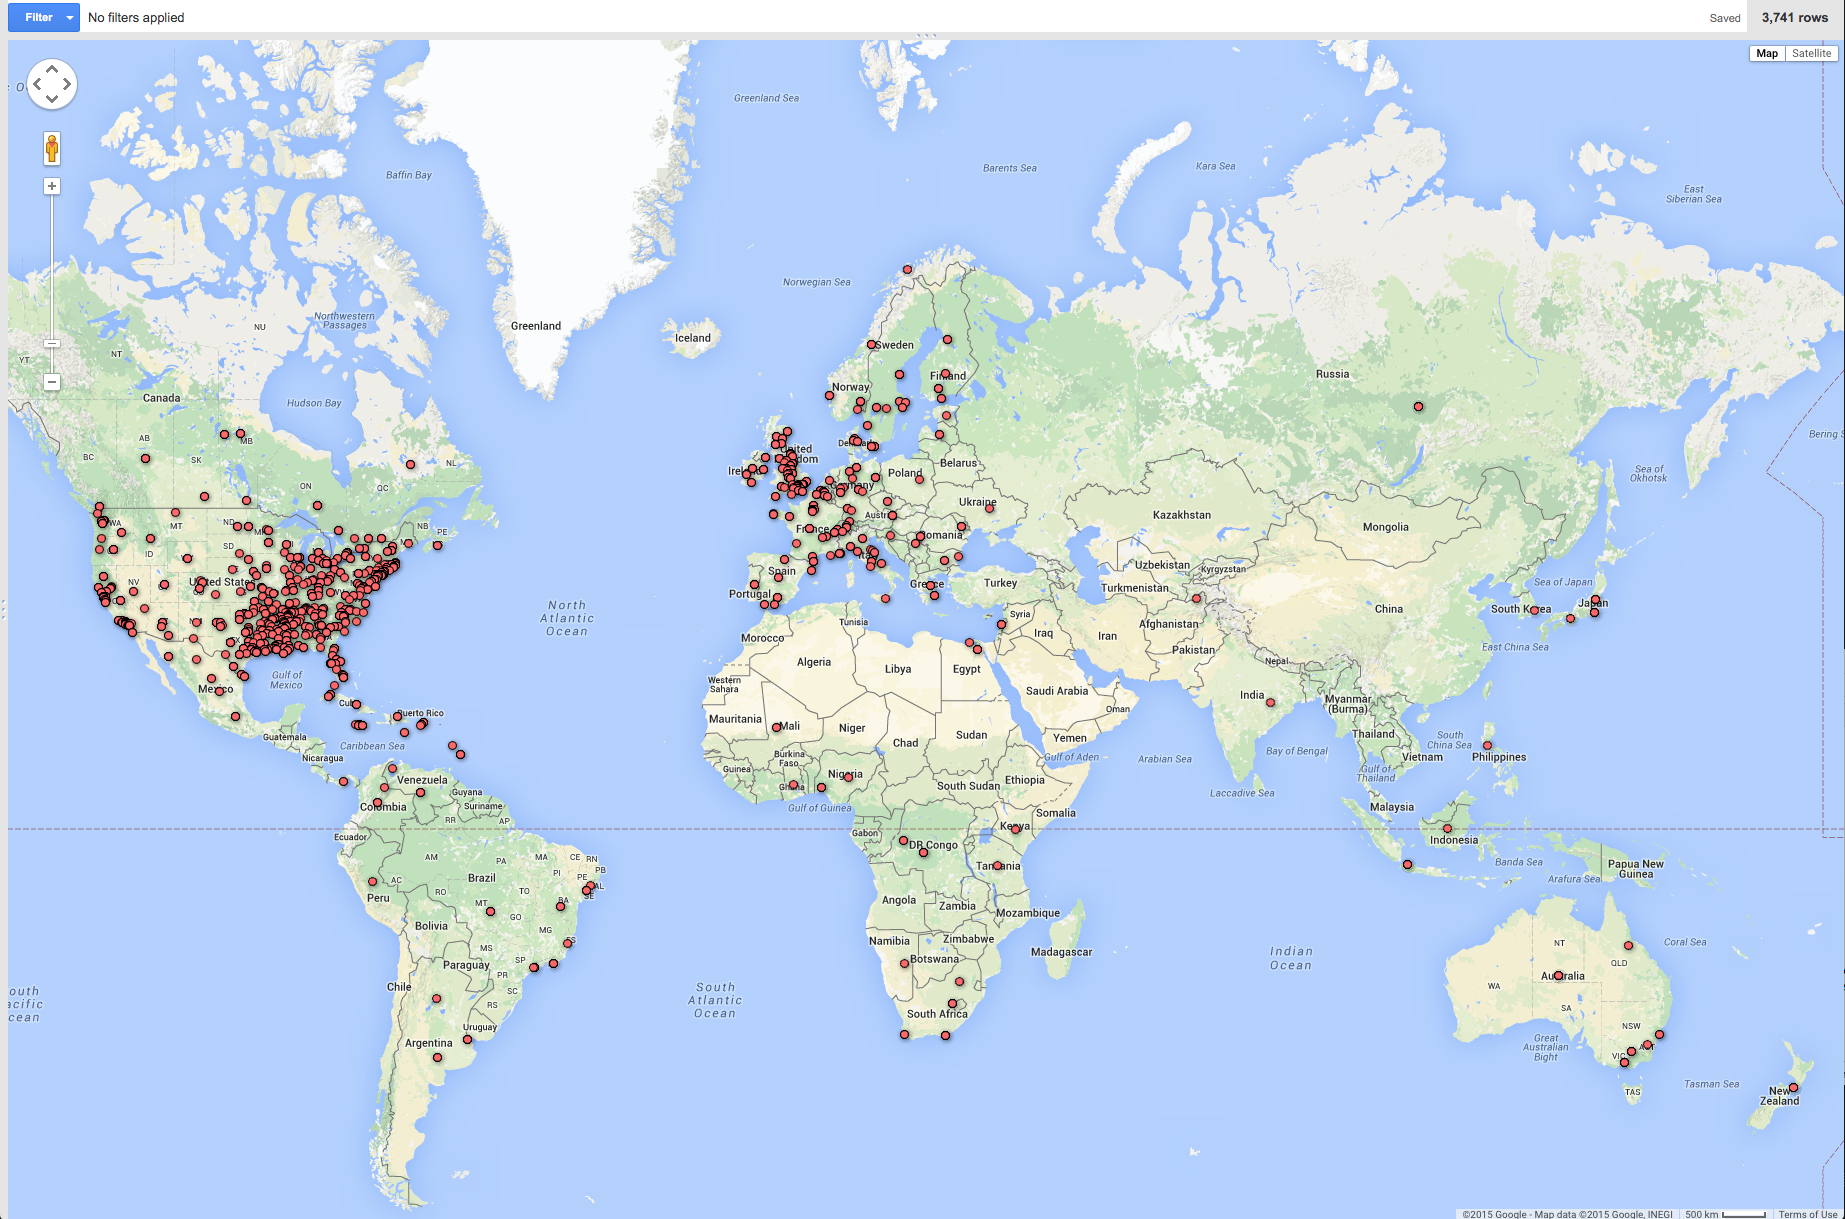

In [2]:
Image(filename='map.png')

Figure 2. Map of all the artistes, using Google Fusion Table. Most of them seem to be clustered in the US and Europe.

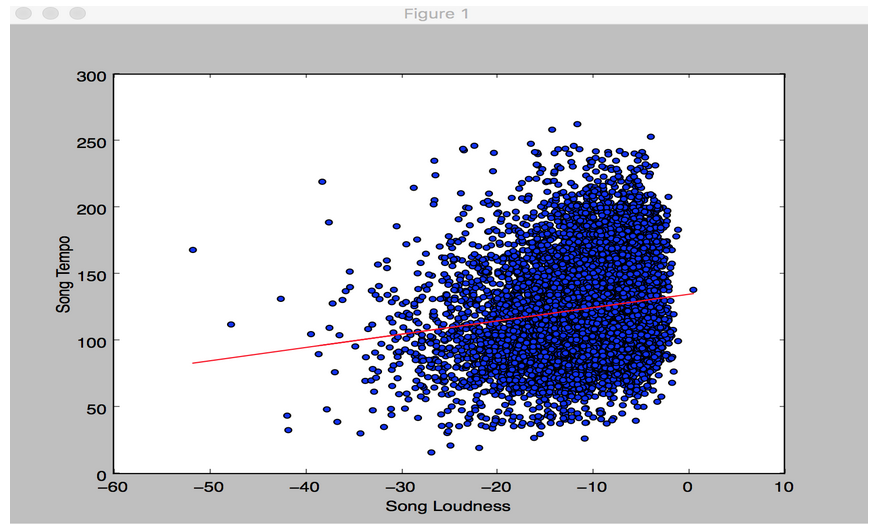

In [3]:
Image(filename='scatter.png')

Figure 3. Scatter plot of Song tempo vs Sound Loudness with a linear regression line. The correlation coefficient r2 = 0.03023750496 which shows the very loose positive correlation between the how fast the song is and how loud it generally is (in dB)


## Surprises
1. One surprise that we found was that in the subset of the song data, all 10,000 songs had not been analyzed for danceability and energy (they were all 0.0). This was going to be one of our features for the prediction model so we will have to think of other features to train our model on. 


## Next Steps


We will likely continue to do basic data analysis to make sure our expectations about the data are well founded, then we will attempt to build a Machine Learning model that uses either Neural Networks or Supervised Learning to predict song popularity based on features available in the data. 